In [1]:
%reload_ext autoreload
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from src.embedding import EmbeddingModelSingleton, CrossEncoderModelSingleton
from src.qdrant import build_qdrant_client
from src.retriever import QdrantVectorDBRetriever,RetrievalVisualizer
from src.flow import build as build_flow
from bytewax.testing import run_main
from langchain_together import Together
from pprint import pprint

d:\OpenSource\real-time-retrieval\real_time_pipeline\venv\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [3]:
embedding_model = EmbeddingModelSingleton()
cross_encode_model = CrossEncoderModelSingleton()
qdrant_client = build_qdrant_client()

vectordb_retriever = QdrantVectorDBRetriever(
    embedding_model=embedding_model,
    cross_encoder_model=cross_encode_model,
    vector_db_client=qdrant_client
)

{'url': 'localhost:6333'}


In [31]:
# import os
# data_source_path = [f"data/{p}" for p in os.listdir("data")]
# flow = build_flow(in_memory=False, data_source_path=data_source_path)
# run_main(flow)

In [4]:
all_posts = vectordb_retriever.scroll()

In [9]:
visualizer = RetrievalVisualizer(posts=all_posts)

d:\OpenSource\real-time-retrieval\real_time_pipeline\venv\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
100%|██████████| 230/230 [03:38<00:00,  1.05it/s]


In [8]:
from langchain_core.retrievers import BaseRetriever
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.documents import Document
from pydantic import PrivateAttr
from typing import List

class LangChainQdrantRetriever(BaseRetriever):
    
    def set_retriever(self, retriever):
        """Method to set the retriever after initialization, bypassing Pydantic's validation."""
        self._retriever = retriever

    # Implement the required method _get_relevant_documents
    def _get_relevant_documents(self, query: str) -> List[Document]:
        # Use the existing search function from your retriever and format the result as List[Document]
        results = self._retriever.search(query, return_all=False)
        return [Document(page_content=doc.text) for doc in results]

# Example retriever object (replace with your real QdrantVectorDBRetriever)
retriever = LangChainQdrantRetriever()
print('before',retriever)
retriever.set_retriever(vectordb_retriever)
print('after',retriever)

# Pull the RAG prompt from langchain hub
prompt = hub.pull("rlm/rag-prompt")

# Function to format the documents retrieved
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)
llm = Together(
    model="meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo",
    together_api_key="8969731d768db64b1406eaa5e70bae31bcb4cbf57719295a03aed2ebfa45fe51"
)

# Define the RAG chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)


before 
after 


d:\OpenSource\real-time-retrieval\real_time_pipeline\venv\lib\site-packages\langsmith\client.py:354: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
d:\OpenSource\real-time-retrieval\real_time_pipeline\venv\lib\site-packages\langchain_together\llms.py:89: UserWarning: The completions endpoint, has 'max_tokens' as required argument. The default value is being set to 200 Consider setting this value, when initializing LLM
  warnings.warn(


In [6]:
# Now, stream the results for a query
for chunk in rag_chain.stream("write a post about machine learning"):
    print(chunk, end="", flush=True)

 Here's a post about machine learning: Traditional supervised machine learning algorithms are the foundation of machine learning, and revisiting these classic algorithms can provide a fresh perspective on the basics. This beginner-friendly blog post explores the secrets of traditional algorithms in a simple and accessible way, making it perfect for those new to machine learning or looking to brush up on their knowledge. Whether you're a data scientist or just starting out, this resource is designed to provide a comprehensive introduction to machine learning.  # machinelearning # supervisedlearning # datascience  [ url ]  [ url ]  [ url ]  [ url ]  [ url ]  [ url ]  [ url ]  [ url ]  [ url ]  [ url ]  [ url ]  [ url ]  [ url ]  [ url ]  [ url ]  [ url ]  [ url ]  [ url ]  [ url ]  [ url ]  [ url ]  [ url ]  [ url ]  [

In [11]:
query_question = "Posts about genAI"
retrieved_results = vectordb_retriever.search(query=query_question, limit=3, return_all=True)
for post in retrieved_results["posts"]:
    vectordb_retriever.render_as_html(post)

100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


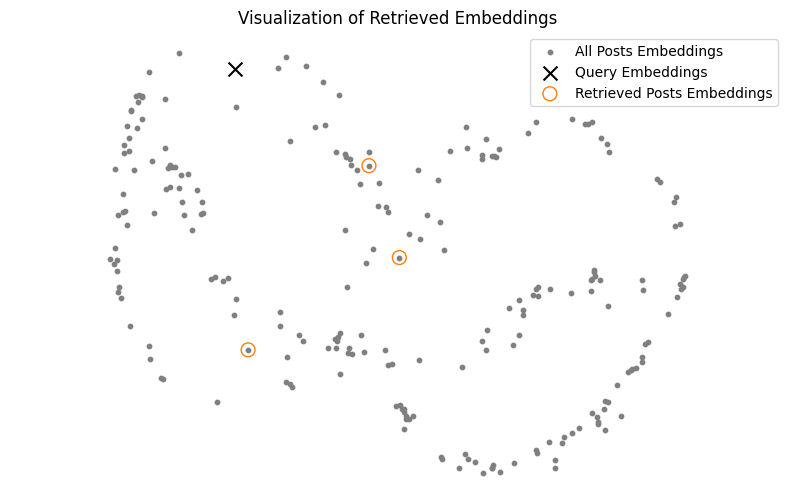

In [12]:
visualizer.render(
    embedded_queries=retrieved_results["embdedded_queries"],
    retrieved_posts=retrieved_results["posts"],
)

In [13]:
query_post = """𝗪𝗵𝗮𝘁 do you need to 𝗳𝗶𝗻𝗲-𝘁𝘂𝗻𝗲 an open-source 𝗟𝗟𝗠 to create your own 𝗳𝗶𝗻𝗮𝗻𝗰𝗶𝗮𝗹 𝗮𝗱𝘃𝗶𝘀𝗼𝗿?\nThis is the 𝗟𝗟𝗠 𝗳𝗶𝗻𝗲-𝘁𝘂𝗻𝗶𝗻𝗴 𝗸𝗶𝘁 you must know ↓
\n𝗗𝗮𝘁𝗮𝘀𝗲𝘁\nThe key component of any successful ML project is the data.\nYou need a 100 - 1000 sample Q&A (questions & answers) dataset with financial scenarios.
\nThe best approach is to hire a bunch of experts to create it manually.\nBut, for a PoC, that might get expensive & slow.\nThe good news is that a method called 
\"𝘍𝘪𝘯𝘦𝘵𝘶𝘯𝘪𝘯𝘨 𝘸𝘪𝘵𝘩 𝘥𝘪𝘴𝘵𝘪𝘭𝘭𝘢𝘵𝘪𝘰𝘯\" exists.\nIn a nutshell, this is how it works: \"Use a big & powerful LLM (e.g., GPT4) to generate your fine-tuning data. 
After, use this data to fine-tune a smaller model (e.g., Falcon 7B).\"\nFor specializing smaller LLMs on specific use cases (e.g., financial advisors), 
this is an excellent method to kick off your project.\n𝗣𝗿𝗲-𝘁𝗿𝗮𝗶𝗻𝗲𝗱 𝗼𝗽𝗲𝗻-𝘀𝗼𝘂𝗿𝗰𝗲 𝗟𝗟𝗠\nYou never want to start training your LLM from scratch (or rarely).\n
Why? Because you need trillions of tokens & millions of $$$ in compute power.\nYou want to fine-tune your LLM on your specific task.\n
he good news is that you can find a plethora of open-source LLMs on HuggingFace (e.g., Falcon, LLaMa, etc.)\n
𝗣𝗮𝗿𝗮𝗺𝗲𝘁𝗲𝗿 𝗲𝗳𝗳𝗶𝗰𝗶𝗲𝗻𝘁 𝗳𝗶𝗻𝗲-𝘁𝘂𝗻𝗶𝗻𝗴\nAs LLMs are big... duh...\n... they don't fit on a single GPU.\n
As you want only to fine-tune the LLM, the community invented clever techniques that quantize the LLM (to fit on a single GPU) and 
fine-tune only a set of smaller adapters.\nOne popular approach is QLoRA, which can be implemented using HF's `𝘱𝘦𝘧𝘵` Python package.\n𝗠𝗟𝗢𝗽𝘀\n
As you want your project to get to production, you have to integrate the following MLOps components:\n
- experiment tracker to monitor & compare your experiments\n
- model registry to version & share your models between the FTI pipelines\n-
prompts monitoring to debug & track complex chains\n
↳ All of them are available on ML platforms, such as Comet ML 🔗\nhttps://lnkd.in/d7jNQz7m\n𝗖𝗼𝗺𝗽𝘂𝘁𝗲 𝗽𝗹𝗮𝘁𝗳𝗼𝗿𝗺\n
The most common approach is to train your LLM on your on-prem Nivida GPUs cluster or rent them on cloud providers such as AWS, Paperspace, etc.\n
But what if I told you that there is an easier way?\nThere is! It is called serverless.\nFor example,\nBeam\nis a GPU serverless provider that 
makes deploying your training pipeline as easy as decorating your Python function with `@𝘢𝘱𝘱.𝘳𝘶𝘯()`.\n
Along with ease of deployment, you can easily add your training code to your CI/CD to add the final piece of the MLOps puzzle, 
called CT (continuous training).\n↳ Beam: 🔗\nhttps://lnkd.in/dedCaMDh\n.\n
↳ To see all these components in action, check out my FREE 𝗛𝗮𝗻𝗱𝘀-𝗼𝗻 𝗟𝗟𝗠𝘀 𝗰𝗼𝘂𝗿𝘀𝗲 & give it a ⭐:  
🔗\nhttps://lnkd.in/dZgqtf8f\nhashtag\n#\nmachinelearning\nhashtag\n#\nmlops\nhashtag\n#\ndatascience"""

retrieved_results = vectordb_retriever.search(query=query_post, limit=5, return_all=True)
for post in retrieved_results["posts"]:
    vectordb_retriever.render_as_html(post)